# Validate

In [1]:
import os
import pickle
import json
from pathlib import Path
from typing import Sequence
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
from numpy import typing as npt
from matplotlib import pyplot as plt
from matplotlib.ticker import MaxNLocator
import statsmodels.api as sm

In [2]:
def plot_ts_events(
		time_grids: Sequence[datetime],
		ts: dict[str, Sequence | npt.NDArray],
		events: dict[str, Sequence | npt.NDArray],
		ts_colors,
		ts_linestyles,
		*,
		ylim=None,
		figsize=(10, 5),
		height_ratios=[3, 1],
):
	fig, (ax_main, ax_events) = plt.subplots(
		nrows=2, ncols=1, figsize=figsize, height_ratios=height_ratios,
	)
	if ylim is not None:
		ax_main.set_ylim(ylim[0], ylim[1])
	# plot time series
	idx_line = 0
	for ts_key, ts_val in ts.items():
		ax_main.plot(
			time_grids, ts_val, label=ts_key,
			color=ts_colors[idx_line],
			linestyle=ts_linestyles[idx_line],
		)
		idx_line += 1
	ax_main.legend(frameon=False)
	ax_main.xaxis.set_major_locator(MaxNLocator(nbins=8))
	xrange = ax_main.get_xlim()
	# plot events
	event_height = 0.2
	ytick = 0
	yticks = []
	yticklabels = []
	for event_key, event_val in events.items():
		yticks.append(ytick)
		yticklabels.append(event_key)
		ax_events.hlines(y=ytick, xmin=xrange[0], xmax=xrange[1], color='black')
		ax_events.vlines(x=event_val, ymin=ytick - event_height, ymax=ytick + event_height, color='black')
		ytick -= 2.5 * event_height
	ax_events.set_xlim(xrange)
	ax_events.get_xaxis().set_visible(False)
	ax_events.set_yticks(yticks)
	ax_events.set_yticklabels(yticklabels)
	return fig, ax_main, ax_events

In [3]:
wd = os.getcwd()
wd_data = Path(os.path.join(wd, '__jsondata__'))
lst_data_json = list(wd_data.glob("*.json"))
lst_data_post = list(wd_data.glob("*.pkl"))
len(lst_data_json), len(lst_data_post)

(13, 13)

In [4]:
contests_data = {
	'contest_id' : [],
	'data_json' : [],
	'data_post' : []
}

for path_json, path_post in zip(lst_data_json, lst_data_post):
	contest_id = path_json.stem.split('_')[1]
	with open(path_json, "r", encoding="utf-8") as f:
		data_json = json.load(f)
	with open(path_post, "rb") as f:
		data_post = pickle.load(f)
	contests_data['contest_id'].append(int(contest_id))
	contests_data['data_json'].append(data_json)
	contests_data['data_post'].append(data_post)

print(contests_data['contest_id'])

[2467, 2762, 2549, 2860, 3928, 4493, 3507, 2435, 3526, 2478, 2454, 2445, 2464]


In [5]:
list(contests_data['data_json'][0].keys())

['start_time',
 'theta',
 'percentage',
 'max_daily_submit',
 'ratio',
 'N_Delta',
 'Delta2f',
 'Ni',
 'Nj',
 'hat_t_i',
 'hat_t_j',
 'hat_y',
 'real_y']

In [6]:
list(contests_data['data_post'][0].keys())

['mu_0',
 'c_i',
 'c_j',
 'sigma',
 'lambda',
 'm_i',
 'm_j',
 'tilde_y',
 'intensity_i',
 'intensity_i_at_events',
 'intensity_j',
 'intensity_j_at_events',
 'effort_gap',
 'hat_y_mean',
 'hat_y_cov']

### Load Data

In [30]:
def calculate_lambda_mle(arr_hat_y, arr_real_y, Delta2f):
	"""
	"""
	n = len(arr_hat_y)
	mse = sum([(hat_y - y)**2 for hat_y, y in zip(arr_hat_y, arr_real_y)])
	return n / mse / Delta2f

def estimate_effort_kde(contest_id: int):
	"""Using kernel density estimation to estimate submisison intensity

	Return: intensity per hour
	"""
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]

	N_Delta = contest_data_json['N_Delta']
	time_grids_f = [i for i in range(N_Delta)]  # float
	hat_t_i_f = np.array(contest_data_json['hat_t_i'])
	hat_t_j_f = np.array(contest_data_json['hat_t_j'])

	kde_i = gaussian_kde(hat_t_i_f, bw_method=0.25)
	kde_j = gaussian_kde(hat_t_j_f, bw_method=0.25)
	density_i = kde_i(time_grids_f)
	density_j = kde_j(time_grids_f)
	intensity_i = density_i * len(hat_t_i_f)
	intensity_j = density_j * len(hat_t_j_f)

	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	time_grids = [start_time + timedelta(hours=i) for i in time_grids_f]
	hat_t_i = [start_time + timedelta(hours=t) for t in hat_t_i_f]
	hat_t_j = [start_time + timedelta(hours=t) for t in hat_t_j_f]
	return time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j

def calculate_sigma_mle(contest_id: int, r_hat) -> float:
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]

	# KDE
	time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j = estimate_effort_kde(contest_id)
	arr_real_y = contest_data_json['real_y']
	Delta2f = contest_data_json['Delta2f']

	# departion
	N = n_i = n_j = 0
	arr_tk = []
	arr_y_tk = []
	arr_sum_intensity_gap = []
	sum_intensity_gap = 0
	for t, y, tau_i, tau_j in zip(time_grids, arr_real_y, intensity_i, intensity_j):
		sum_intensity_gap += tau_i - tau_j
		if n_i < len(hat_t_i) and t - timedelta(hours=1) < hat_t_i[n_i] < t:
			if len(arr_tk) > 0 and hat_t_i[n_i] <= arr_tk[-1]:
				n_i += 1
				continue
			arr_tk.append(hat_t_i[n_i])
			arr_y_tk.append(y)
			arr_sum_intensity_gap.append(24 * sum_intensity_gap * Delta2f)
			sum_intensity_gap = 0
			n_i += 1
			N += 1
		if n_j < len(hat_t_j) and t - timedelta(hours=1) < hat_t_j[n_j] < t:
			if len(arr_tk) > 0 and hat_t_j[n_j] <= arr_tk[-1]:
				n_j += 1
				continue
			arr_tk.append(hat_t_j[n_j])
			arr_y_tk.append(y)
			arr_sum_intensity_gap.append(24 * sum_intensity_gap * Delta2f)
			sum_intensity_gap = 0
			n_j += 1
			N += 1
	arr_sum_intensity_gap = arr_sum_intensity_gap[1:]  # drop the first

	# MLE
	arr_delta_tk = [(arr_tk[ii + 1] - arr_tk[ii]).total_seconds() / 3600 * Delta2f for ii in range(N - 1)]
	arr_delta_y_tk = [arr_y_tk[ii + 1] - arr_y_tk[ii] for ii in range(N - 1)]
	zip_3 = zip(arr_delta_y_tk, arr_sum_intensity_gap, arr_delta_tk)
	mle_sigma_squared = np.mean([(Xk - Mk / r_hat)**2 / Tk for Xk, Mk, Tk in zip_3])
	return float(mle_sigma_squared**0.5)


In [31]:
def display_estimation_results():
	data = []
	for id, json_data, posteriors in zip(
		contests_data['contest_id'], contests_data['data_json'], contests_data['data_post']
	):
		record = {
			'Id': id,
			'Ni': json_data['Ni'],
			'Nj': json_data['Nj'],
			'prize (k, USD)': json_data['theta'],
			'Percentage (%)': json_data['percentage'],
			'lambda_mle': calculate_lambda_mle(json_data['hat_y'], json_data['real_y'], json_data['Delta2f']),
			'lambda_post_mean': posteriors['lambda'].mean(),
			'sigma_mle': calculate_sigma_mle(id, 15),
			'sigma_post_mean': posteriors['sigma'].mean(),
		}
		data.append(record)
	return pd.DataFrame(data)

In [32]:
cross_contests = display_estimation_results()
cross_contests

,Id,Ni,Nj,"prize (k, USD)",Percentage (%),lambda_mle,lambda_post_mean,sigma_mle,sigma_post_mean
0,2467,9,6,10.00,30.0,93.008188,7.203644,5.215768,9.753148
1,2762,12,21,1.00,35.0,0.017897,0.100253,7.079357,9.192004
2,2549,13,9,0.50,30.0,0.164106,0.197386,56.540163,9.847563
3,2860,16,5,1.00,30.0,0.033051,0.426980,30.082486,9.668195
4,3928,15,21,0.68,70.0,2.555218,7.237237,27.711666,9.847612
5,4493,19,14,10.00,40.0,1.052005,3.646746,18.329991,9.762965
6,3507,14,11,0.50,33.0,0.013709,0.006977,23.347580,3.089605
7,2435,19,13,0.50,30.0,0.045923,0.182873,3.069758,9.912726
8,3526,15,13,5.00,20.0,0.549113,0.143413,32.057610,7.390572
9,2478,12,13,0.95,30.0,5.533020,0.350067,22.453945,9.835965


#### Effort Display

In [33]:
def plot_contest_data(contest_id: int):
	"""
	"""
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]
	contest_data_post = contests_data['data_post'][contest_idx]
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	N_Delta = contest_data_json['N_Delta']
	time_grids = [start_time + i * timedelta(hours=1) for i in range(N_Delta)]
	arr_hat_y = contest_data_json['hat_y']
	arr_real_y = contest_data_json['real_y']
	arr_tilde_y = contest_data_post['tilde_y'].mean(axis=0)
	hat_t_i = [start_time + timedelta(hours=t) for t in contest_data_json['hat_t_i']]
	hat_t_j = [start_time + timedelta(hours=t) for t in contest_data_json['hat_t_j']]
	fig, ax_main, ax_events = plot_ts_events(
		time_grids=time_grids,
		ts={
			r'real output gap ($y_t$)': arr_real_y,
			r'observed output gap ($\hat{y}_t$)': arr_hat_y,
			r'perceived output gap ($\tilde{y}_t$)': arr_tilde_y[:-1],
		},
		events={
			r'player $i$': hat_t_i,
			r'player $j$': hat_t_j,
		},
		ts_colors = ['blue', 'black', 'black'],
		ts_linestyles=['solid', 'solid', 'dashed']
	)
	return fig, ax_main, ax_events

def plot_post_efforts(contest_id: int):
	"""
	"""
	contest_idx = contests_data['contest_id'].index(contest_id)
	contest_data_json = contests_data['data_json'][contest_idx]
	contest_data_post = contests_data['data_post'][contest_idx]
	start_time = datetime.fromtimestamp(contest_data_json['start_time'])
	N_Delta = contest_data_json['N_Delta']
	time_grids = [start_time + i * timedelta(hours=1) for i in range(N_Delta)]
	i_effort_dynamic = contest_data_post['m_i'].mean(axis=0)
	j_effort_dynamic = contest_data_post['m_j'].mean(axis=0)
	plt.figure(figsize=(10, 3))
	plt.plot(np.array(time_grids), i_effort_dynamic, label='player i')
	plt.plot(np.array(time_grids), j_effort_dynamic, label='player j')
	plt.legend()
	plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=8))
	plt.show()

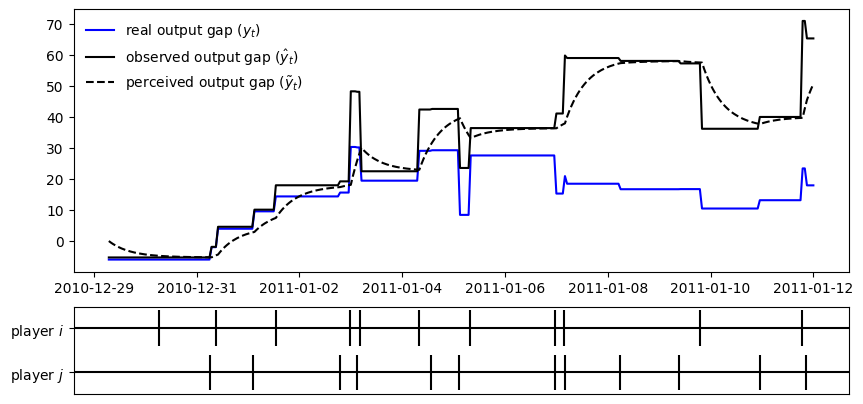

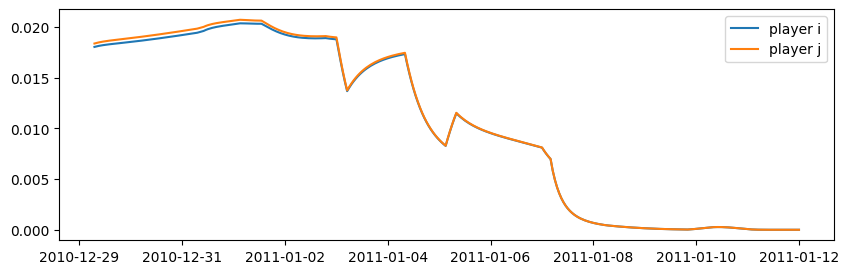

In [34]:
contest_id = 2464
_ = plot_contest_data(contest_id)
plot_post_efforts(contest_id)

#### Validate $\sigma$

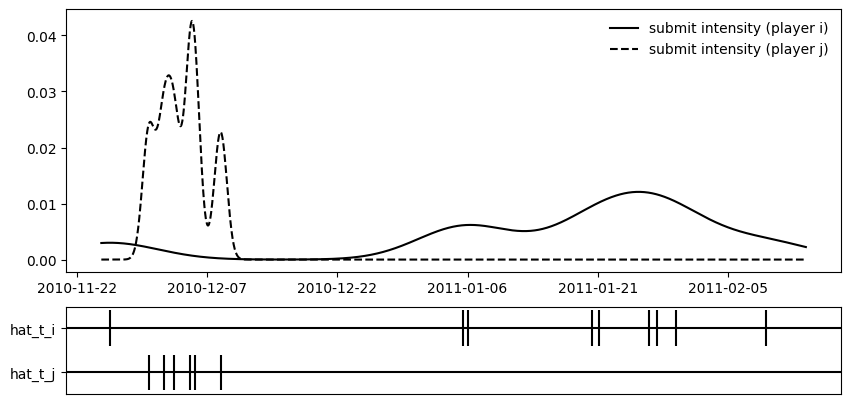

In [35]:
# Display submission intensity
contest_id = 2467
time_grids, hat_t_i, intensity_i, hat_t_j, intensity_j = estimate_effort_kde(contest_id)
_ = plot_ts_events(time_grids, ts={
	'submit intensity (player i)': intensity_i,
	'submit intensity (player j)': intensity_j,
}, events={
	'hat_t_i': hat_t_i,
	'hat_t_j': hat_t_j,
}, ts_colors = ['black', 'black'], ts_linestyles = ['solid', 'dashed'],
)

In [38]:
log_sigma_hat_bayes = np.log(1 + cross_contests['sigma_post_mean'])
log_sigma_hat_real = np.log(1 + cross_contests['sigma_mle'])
X = sm.add_constant(log_sigma_hat_real)
model_sigma = sm.OLS(log_sigma_hat_bayes, X).fit()
log_sigma_hat_fit = model_sigma.predict(X)
display(model_sigma.summary())

/Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        sigma_post_mean   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                 -0.073
Method:                 Least Squares   F-statistic:                    0.1846
Date:                Fri, 23 May 2025   Prob (F-statistic):              0.676
Time:                        17:42:14   Log-Likelihood:               -0.73983
No. Observations:                  13   AIC:                             5.480
Df Residuals:                      11   BIC:                             6.610
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3864      0.288      8.292      0.000       1.753       3.020
sigma_mle     -0.0415      0.097     -0.430      0.676      -0.254       0.171
==============================================================================
Omnibus:                       29.459   Durbin-Watson:                   2.241
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.464
Skew:                          -2.703   Prob(JB):                     1.21e-08
Kurtosis:                       9.173   Cond. No.                         12.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

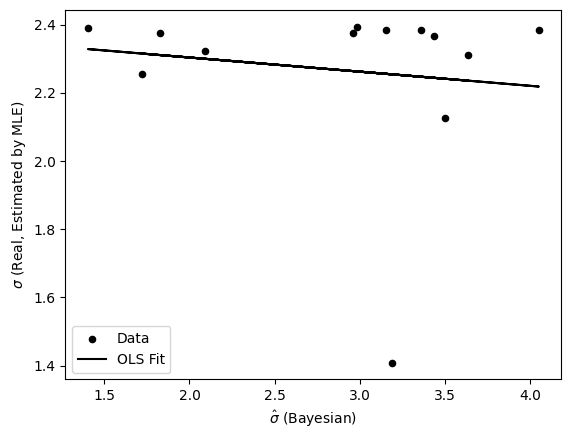

In [41]:
plt.scatter(log_sigma_hat_real, log_sigma_hat_bayes, s=20, label="Data", color="black", )
plt.plot(log_sigma_hat_real, log_sigma_hat_fit, label="OLS Fit", color="black")
plt.legend()
plt.xlabel(r"$\hat\sigma$ (Bayesian)")
plt.ylabel(r"$\sigma$ (Real, Estimated by MLE)")
plt.show()

#### Validate $\lambda$

In [16]:
log_lamb_hat_bayes = np.log(1 + cross_contests['lambda_post_mean'])
log_lamb_hat_real = np.log(1 + cross_contests['lambda_mle'])
X = sm.add_constant(log_lamb_hat_bayes)
model_lambda = sm.OLS(log_lamb_hat_real, X).fit()
log_lamb_hat_fit = model_lambda.predict(X)
display(model_lambda.summary())

/Users/zhuanglinsheng/Documents/Github/kaggle-contest-design/.venv/lib/python3.13/site-packages/scipy/stats/_axis_nan_policy.py:430: UserWarning: `kurtosistest` p-value may be inaccurate with fewer than 20 observations; only n=13 observations were given.
  return hypotest_fun_in(*args, **kwds)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             lambda_mle   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.269
Method:                 Least Squares   F-statistic:                     5.413
Date:                Fri, 23 May 2025   Prob (F-statistic):             0.0401
Time:                        17:29:03   Log-Likelihood:                -18.492
No. Observations:                  13   AIC:                             40.98
Df Residuals:                      11   BIC:                             42.11
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.1562      0.394      0.396      0.700      -0.712       1.024
lambda_post_mean     0.8603      0.370      2.327      0.040       0.046       1.674
==============================================================================
Omnibus:                        7.531   Durbin-Watson:                   1.350
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                3.677
Skew:                           1.124   Prob(JB):                        0.159
Kurtosis:                       4.317   Cond. No.                         2.15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

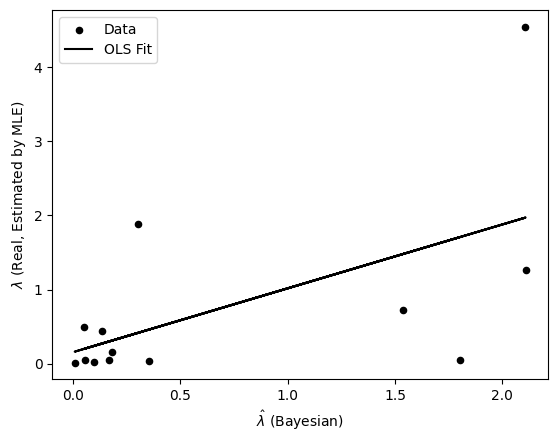

In [17]:
plt.scatter(log_lamb_hat_bayes, log_lamb_hat_real, s=20, label="Data", color="black", )
plt.plot(log_lamb_hat_bayes, log_lamb_hat_fit, label="OLS Fit", color="black")
plt.legend()
plt.xlabel(r"$\hat\lambda$ (Bayesian)")
plt.ylabel(r"$\lambda$ (Real, Estimated by MLE)")
plt.show()